In [10]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random
from tqdm import tqdm

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload 2
from classes.fpst import *

In [12]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

dir = os.path.join(data_dir, "SPST_perfect")

In [62]:
file = loadmat(os.path.join(dir, "FPSTdata_2_pol-60.mat"))

fpsts_26 = file["fpsts"]
forbiden = file["forbiden"][0]
coords_26 = file["coords"]

In [72]:
dir_path = os.path.join(data_dir, "interpol_64", "FPST_3MI2_-60")
total_tasks = 10000 #(512 * 512)

fpsts_64, coords_64 = load_FPST(dir_path, total_tasks)

Overhead done, starting the loop


Process: 100%|██████████| 10000/10000 [00:12<00:00, 824.68task/s]


C:\Users\f076048\AppData\Local\Temp\ipykernel_14940\3024085124.py:8: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(np.abs(fpst_64)), cmap="jet")


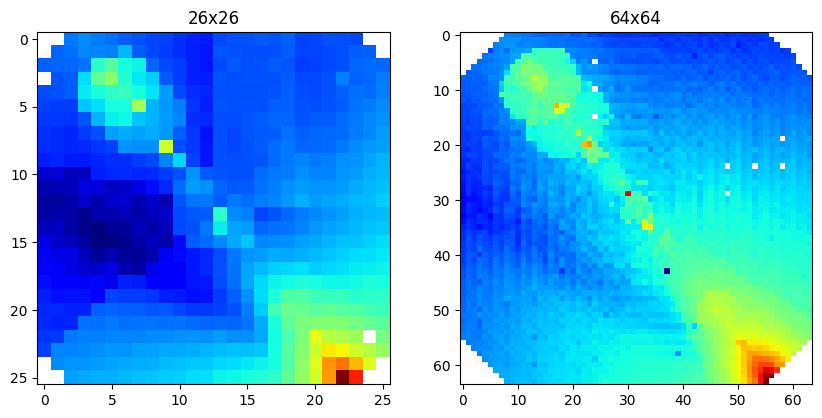

In [78]:
ind = random.randint(0, len(fpsts_64) - 1)
fpst_26 = fpsts_26[ind]
fpst_64 = fpsts_64[ind]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.log10(np.abs(fpst_26)), cmap="jet")
axs[0].set_title("26x26")
axs[1].imshow(np.log10(np.abs(fpst_64)), cmap="jet")
axs[1].set_title("64x64")
# plot the colorbar
plt.show()

In [15]:
print(np.min(fpsts_64), np.max(fpsts_64))

-4.3321776388438593e-07 0.0041695861145854


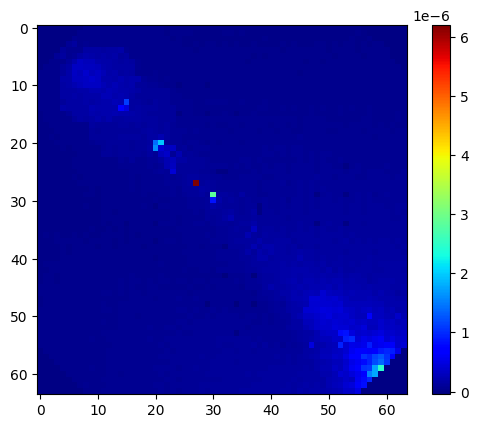

In [16]:
ind = 3571

fpst_64 = fpsts_64[ind]

plt.imshow(fpst_64, cmap="jet")
plt.colorbar()
plt.show()

In [17]:
from PIL import Image

fpsts_32 = np.empty((len(fpsts_26), 32, 32))
for i in range(len(fpsts_26)):
    # Interpolate the map to 32x32 using the nearest neighbour method
    fpsts_32[i] = np.array(Image.fromarray(fpsts_26[i]).resize((32, 32), resample=Image.NEAREST))

# free memory
del fpsts_26

In [11]:
def preprocess_data(maps):
    def pretreatment(x):
        x = np.abs(x)
        x[x == 0] = 1e-15
        x = np.log10(x)
        return x

    # maps = np.array(list(map(pretreatment, maps)))

    # normalize data between 0 and 1 using min and max values from the dataframe
    min = []
    max = []
    for i in range(len(maps)):
        min_val = np.min(maps[i])
        max_val = np.max(maps[i])
        maps[i] = (maps[i] - min_val) / (max_val - min_val)
        min.append(min_val)
        max.append(max_val)

    return maps, min, max

def rev_preprocess(map, min, max):
    map = map * (max - min) + min
    # map = np.power(10, map)
    return map

In [18]:
fpsts_32 = np.nan_to_num(fpsts_32)

In [19]:
''' fpsts_32, min_32, max_32 = preprocess_data(fpsts_32)
fpsts_64, min_64, max_64 = preprocess_data(fpsts_64) '''
fpsts_32 = fpsts_32 / np.max(fpsts_32)
fpsts_64 = fpsts_64 / np.max(fpsts_64)

6300


C:\Users\f076048\AppData\Local\Temp\ipykernel_14940\201334414.py:8: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(np.abs(fpst_32)), cmap="jet")
C:\Users\f076048\AppData\Local\Temp\ipykernel_14940\201334414.py:10: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(np.abs(fpst_64)), cmap="jet")


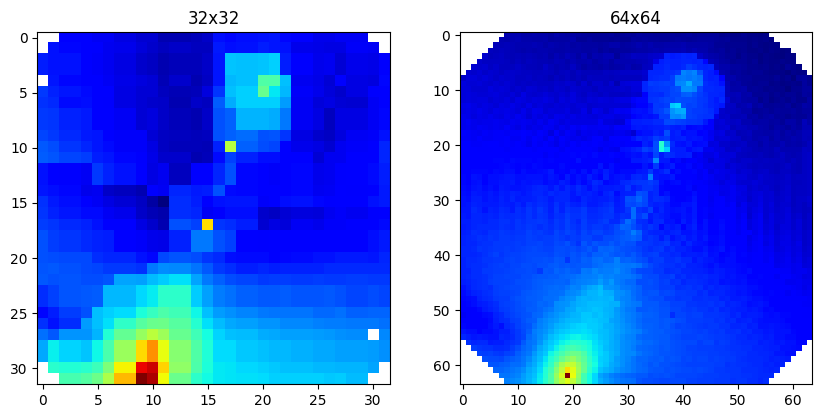

In [59]:
ind = random.randint(0, len(fpsts_64))
print(ind)

fpst_32 = fpsts_32[ind]
fpst_64 = fpsts_64[ind]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.log10(np.abs(fpst_32)), cmap="jet")
axs[0].set_title("32x32")
axs[1].imshow(np.log10(np.abs(fpst_64)), cmap="jet")
axs[1].set_title("64x64")
plt.show()

In [30]:
print(coords_64[518])

[68.5 52.5]


In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

In [16]:
# Create the autoencoder model
# 32x32x1 -> 64x64x1

ae = Sequential()

ae.add(Input(shape=(32, 32, 1)))

# Encoder (32x32x1 -> 16x16x8)
ae.add(Conv2D(8, (3, 3), activation="relu", padding="same"))
ae.add(MaxPooling2D((2, 2), padding="same"))

# (16x16x8 -> 8x8x16)
ae.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
ae.add(MaxPooling2D((2, 2), padding="same"))

# Middle layer (8x8x16 -> 8x8x32)
ae.add(Conv2D(32, (3, 3), activation="relu", padding="same"))

# Decoder (8x8x32 -> 16x16x16)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(16, (3, 3), activation="relu", padding="same"))

# (16x16x16 -> 32x32x8)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(8, (3, 3), activation="relu", padding="same"))

# (32x32x8 -> 64x64x1)
ae.add(UpSampling2D((2, 2)))
ae.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

ae.compile(optimizer="adadelta", loss="mean_squared_error")

In [ ]:
#ae.summary()

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(fpsts_32[:total_tasks], fpsts_64, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [19]:
''' X_train = X_train[:1000]
Y_train = Y_train[:1000] '''

''' X_train = X_train.numpy()
Y_train = Y_train.numpy() '''

X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.expand_dims(Y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)

In [20]:
ae.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 13s 60ms/step - loss: 0.2498 - val_loss: 0.2496
Epoch 2/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2494 - val_loss: 0.2492
Epoch 3/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2490 - val_loss: 0.2488
Epoch 4/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2485 - val_loss: 0.2483
Epoch 5/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2480 - val_loss: 0.2477
Epoch 6/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2474 - val_loss: 0.2471
Epoch 7/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2467 - val_loss: 0.2464
Epoch 8/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2460 - val_loss: 0.2456
Epoch 9/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2452 - val_loss: 0.2448
Epoch 10/10
200/200 [==============================] - 11s 56ms/step - loss: 0.244

In [60]:
ind = random.randint(0, X_test.shape[0]-1)
pred = ae.predict(X_test[ind:ind+1])[0,:,:,0]
print(pred.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.log10(np.abs(Y_test[ind])), cmap="jet")
axs[0].set_title("label")
axs[1].imshow(np.log10(np.abs(pred)), cmap="jet")
axs[1].set_title("pred")
plt.show()

NameError: name 'X_test' is not defined